# Определение легендарного покемона по его характеристикам используя метод опорных векторов

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)

In [24]:
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [25]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SN           800 non-null    int64 
 1   Name         800 non-null    object
 2   Type 1       800 non-null    object
 3   Type 2       414 non-null    object
 4   HP           800 non-null    int64 
 5   Attack       800 non-null    int64 
 6   Defense      800 non-null    int64 
 7   Sp. Attack   800 non-null    int64 
 8   Sp. Defense  800 non-null    int64 
 9   Speed        800 non-null    int64 
 10  Generation   800 non-null    int64 
 11  Legendary    800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### **Задача.** Выберите бинарную переменную (или сконструируйте из количественной)

Из данного списка можно назначить переменную `Legendary` - `target`

### **Задача.** Выберите несколько объясняющих переменных

Мультиколлинеарность не представляет проблемы для SVM. Можно взять все числовые переменные.

### **Задача.** Разделите датасет на обучающую и тестовую выборки

In [26]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(
    dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"]],
    dataframe["Legendary"],
    test_size=0.3,
    random_state=42,
    stratify=dataframe["Legendary"],
)

### **Задача.** Обучите модель опорных векторов на обучающей выборке

In [27]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Нормализация данных
preprocessor = ColumnTransformer(
    transformers=(
        (
            "num",
            StandardScaler(),
            make_column_selector(dtype_include=["int64"]),
        ),
    ),
)

model = Pipeline([("preprocessing", preprocessor), ("regressor", SVC(kernel="linear"))])

model.fit(train_features, train_target)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f88f4d878d0>),))),
                ('regressor', SVC(kernel='linear'))])

### Задача. Постройте график с разделяющей линией

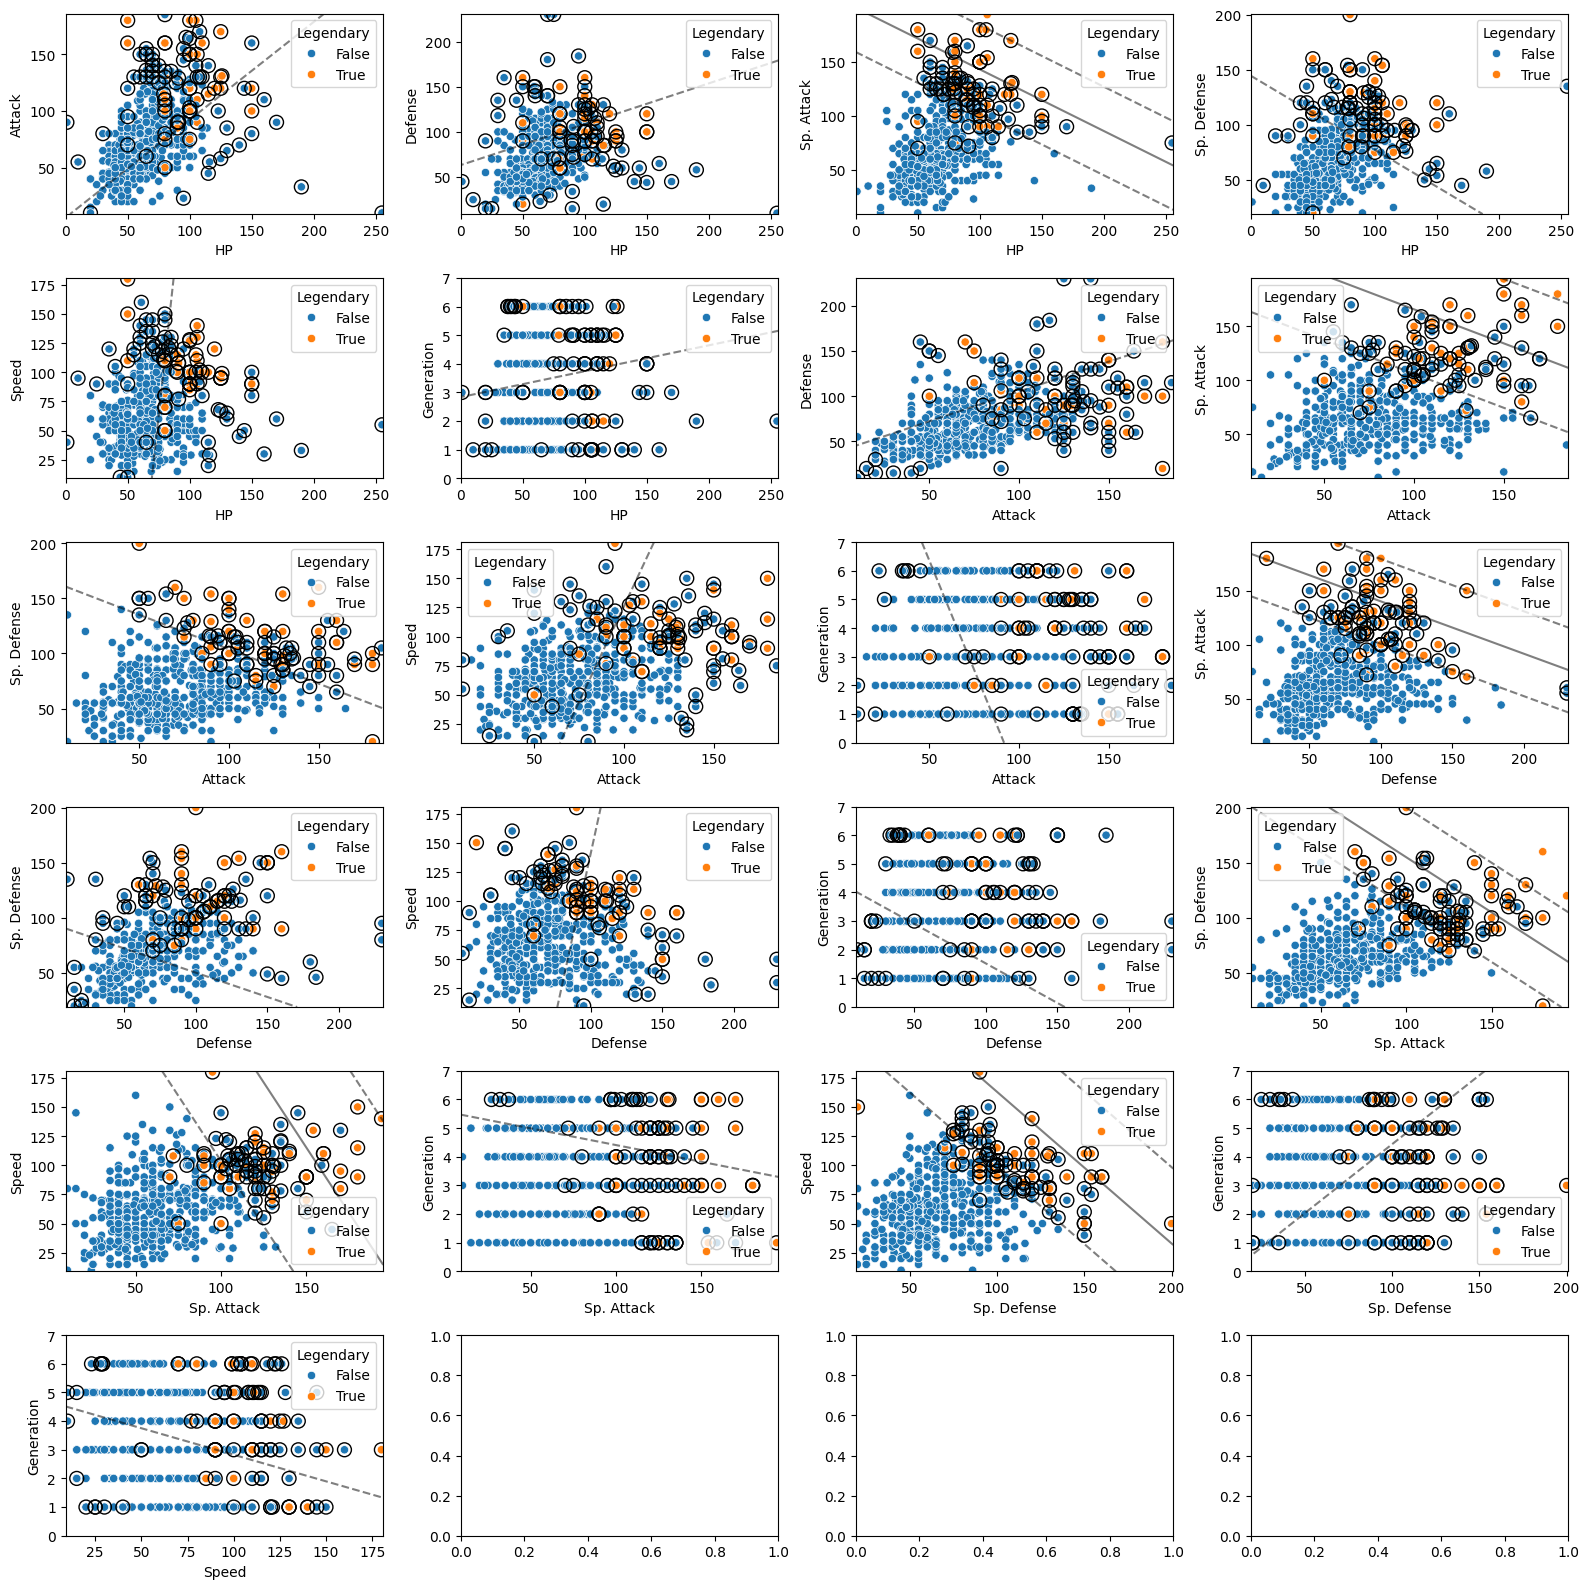

In [28]:
from itertools import combinations

from sklearn.inspection import DecisionBoundaryDisplay

# Копия датафрейма с таргет переменной для 1 графика с точками
train_features_with_target = train_features.copy()
train_features_with_target["Legendary"] = train_target
# Всевозможные комбинации фичей друг с другом
colpars = list(combinations(["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"], 2))

# Матрица с графиками, расчет исходя из количества комбинаций
n = len(colpars) ** 0.5 + 0.5
n = int(n)
fig, axes = plt.subplots(n + 1, n - 1, figsize=(16, 16))

# Для каждой из комбинаций график с разделяющей линией
for colpar, ax in zip(colpars, axes.flat):
    colpar = list(colpar)
    model.fit(train_features[colpar], train_target)
    # возврат координат векторов из нормализованных к изначальным координатам
    scaler = model.named_steps["preprocessing"].named_transformers_["num"]
    svr = model.named_steps["regressor"]
    support_vectors_original = scaler.inverse_transform(svr.support_vectors_)

    # построение фичей
    sns.scatterplot(data=train_features_with_target, x=colpar[0], y=colpar[1], hue="Legendary", ax=ax)

    # разделяющая линия
    DecisionBoundaryDisplay.from_estimator(
        model,
        train_features_with_target[colpar],
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
        ax=ax,
    )

    # обводка опорных векторов
    ax.scatter(
        support_vectors_original[:, 0],
        support_vectors_original[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )

plt.tight_layout()
plt.show()

### **Задача** Проведите подбор гиперпараметров с помощью GridSearchCV

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "regressor__C": [0.1, 1, 10, 100],
    "regressor__gamma": [0.001, 0.01, 0.1, 1],
    "regressor__kernel": ["rbf", "linear"],
}
grid = GridSearchCV(model, param_grid, scoring="recall")
grid.fit(train_features, train_target)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=(('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f88f4d878d0>),))),
                                       ('regressor', SVC(kernel='linear'))]),
             param_grid={'regressor__C': [0.1, 1, 10, 100],
                         'regressor__gamma': [0.001, 0.01, 0.1, 1],
                         'regressor__kernel': ['rbf', 'linear']},
             scoring='recall')

Наилучшие результаты модель с параметрами

In [30]:
grid.best_params_

{'regressor__C': 100, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}

### **Задача.** Сделайте предсказания целевой переменной для тестовой выборки

In [31]:
test_predict = grid.predict(test_features)

### **Задача.** Постройте матрицу ошибок

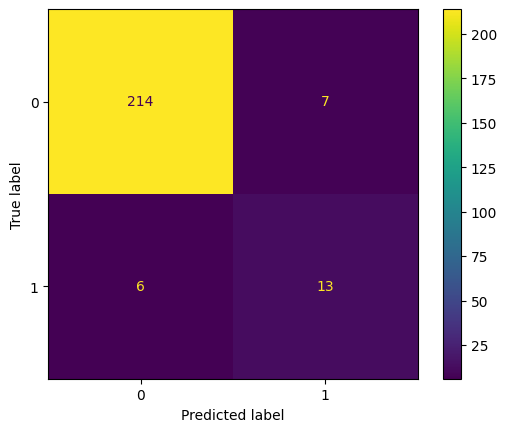

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)
disp = ConfusionMatrixDisplay(conf_m)
disp.plot()
plt.show()

### **Задача.** Рассчитайте метрики качества

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_target, y_pred=test_predict))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       221
        True       0.65      0.68      0.67        19

    accuracy                           0.95       240
   macro avg       0.81      0.83      0.82       240
weighted avg       0.95      0.95      0.95       240



### **Задача.** Сделайте выводы относительно полученной модели, ее качества и полученных зависимостей

Полнота (`recall`) составляет 0.68 - это значит что 32% легендарных покемонов были отмечены обычными (не распознаны), что является неплохим результатом в данной задаче. В тоже время `precision` составляет 0.65 это означает что ложноположительные результаты составляют 35% (покемоны которые были классифицированы как легендарные на самом деле такими не являются). Также стоит отметить, что удается отсеять большой пласт обычных покемонов около 97% (`recall` для False). В целом учитывая дисбаланс классов точность и полнота составляют 0.95, но эта метрика не учитывает слабую производительность в отношении класса легендарных покемонов.